
# PlantDisease ML Pipeline
This notebook walks through an end-to-end Machine Learning pipeline using the PlantVillage plant disease image dataset.

In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

In [3]:
%pip install tensorflow matplotlib scikit-learn pillow tqdm pandas seaborn

In [4]:

# Setup - run these once in your environment if needed.
# If running locally in an environment where packages are already installed, you can skip the pip installs.
import os
from pathlib import Path
import json
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd

print('python executable:', os.sys.executable)
print('cwd:', os.getcwd())


python executable: /usr/bin/python3
cwd: /content



## Data acquisition

1. Download the PlantVillage dataset from Kaggle: https://www.kaggle.com/datasets/emmarex/plantdisease
2. Unzip the dataset and place the image folders in `data/raw/`. The expected layout is:

```
data/
  raw/
    Apple___Apple_scab/
      img1.jpg
      img2.jpg
      ...
    Potato___Early_blight/
    ...
```

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [6]:
import shutil
from pathlib import Path

# The 'path' variable from the previous cell (kagglehub.dataset_download) contains
# the location of the downloaded dataset, e.g., '/kaggle/input/plantdisease'
source_path = Path(path + "/PlantVillage")

# Define the RAW_DIR as used in other cells for consistency
RAW_DIR = Path('data/raw')

# Create the raw data directory if it doesn't exist
RAW_DIR.mkdir(parents=True, exist_ok=True)

print(f"Copying data from {source_path} to {RAW_DIR}")

# Iterate over the contents of the source_path
# and copy them into the RAW_DIR.
for item in source_path.iterdir():
    destination_path = RAW_DIR / item.name
    if item.is_dir():
        if destination_path.exists():
            # If the destination directory already exists, remove it before copying
            # to ensure a clean copy and prevent 'FileExistsError' with shutil.copytree
            print(f"Removing existing directory {destination_path} before copying.")
            shutil.rmtree(destination_path)
        shutil.copytree(item, destination_path)
    else:
        # In case there are files directly in the root of the downloaded dataset
        shutil.copy2(item, destination_path)

print("Dataset successfully added to /data/raw.")

Copying data from /kaggle/input/plantdisease/PlantVillage to data/raw
Dataset successfully added to /data/raw.


In [7]:

# Paths - adjust if your data is elsewhere
RAW_DIR = Path('data/raw')
TRAIN_DIR = Path('data/train')
TEST_DIR = Path('data/test')
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

def get_class_counts(path):
    path = Path(path)
    classes = []
    counts = {}
    for d in sorted(path.iterdir()):
        if d.is_dir():
            n = len(list(d.glob('*')))
            counts[d.name] = n
    return counts

# show counts if data/raw exists
if RAW_DIR.exists():
    counts = get_class_counts(RAW_DIR)
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    display(df_counts.head(20))
else:
    print('Data directory not found. Please place the dataset in data/raw/ as described above.')


,count
Tomato__Tomato_YellowLeaf__Curl_Virus,3209
Tomato_Bacterial_spot,2127
Tomato_Late_blight,1909
Tomato_Septoria_leaf_spot,1771
Tomato_Spider_mites_Two_spotted_spider_mite,1676
Tomato_healthy,1591
Pepper__bell___healthy,1478
Tomato__Target_Spot,1404
Potato___Early_blight,1000
Potato___Late_blight,1000


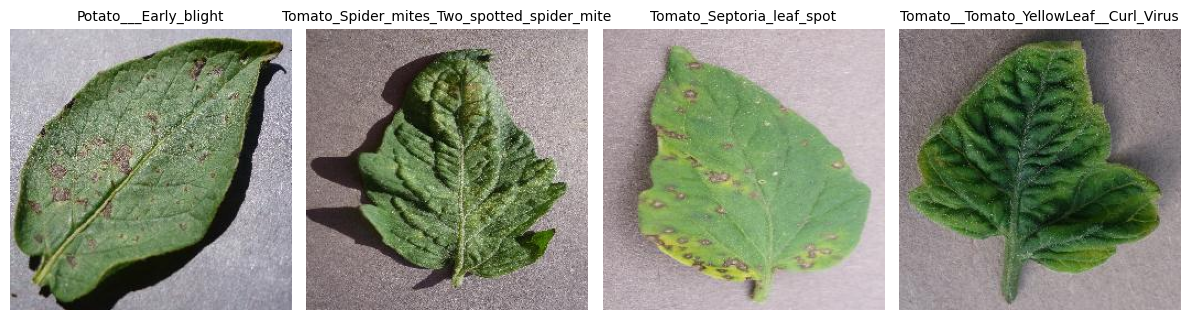

In [8]:

# Display a few sample images from different classes
if RAW_DIR.exists():
    classes = [d for d in RAW_DIR.iterdir() if d.is_dir()]
    sample_classes = classes[:4]
    plt.figure(figsize=(12,6))
    i = 1
    for c in sample_classes:
        imgs = list(c.glob('*'))[:3]
        # show first image from each of the first 4 classes
        img = Image.open(imgs[0]).convert('RGB')
        plt.subplot(1,4,i)
        plt.imshow(img)
        plt.title(c.name, fontsize=10)
        plt.axis('off')
        i += 1
    plt.tight_layout()
else:
    print('No raw data to visualize.')


In [9]:

# Preprocessing utilities
from sklearn.model_selection import train_test_split

IMG_SIZE = (224,224)  # model input size

def split_and_prepare(raw_dir=RAW_DIR, train_dir=TRAIN_DIR, test_dir=TEST_DIR, test_size=0.15, seed=42):
    raw_dir = Path(raw_dir)
    train_dir = Path(train_dir); test_dir = Path(test_dir)
    if train_dir.exists(): shutil.rmtree(train_dir)
    if test_dir.exists(): shutil.rmtree(test_dir)
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    classes = [d for d in raw_dir.iterdir() if d.is_dir()]
    class_map = {}
    for c in classes:
        imgs = [p for p in c.glob('*') if p.suffix.lower() in ['.jpg','.png','.jpeg']]
        if len(imgs) == 0: continue
        labels = [c.name]*len(imgs)
        train_files, test_files = train_test_split(imgs, test_size=test_size, random_state=seed, stratify=labels)
        # copy files
        (train_dir/c.name).mkdir(parents=True, exist_ok=True)
        (test_dir/c.name).mkdir(parents=True, exist_ok=True)
        for f in train_files:
            shutil.copy(f, train_dir/c.name/f.name)
        for f in test_files:
            shutil.copy(f, test_dir/c.name/f.name)
        class_map[c.name] = {'train': len(train_files), 'test': len(test_files)}
    # Save manifest
    with open(MODELS_DIR/'class_manifest.json','w') as fh:
        json.dump(class_map, fh, indent=2)
    return class_map

# Run split if raw exists
if RAW_DIR.exists():
    manifest = split_and_prepare()
    print('Split complete. Example class counts:')
    print(pd.DataFrame(manifest).T.head())
else:
    print('Raw data not found - skipping split.')


Split complete. Example class counts:
                                             train  test
Potato___Early_blight                          850   150
Tomato_Spider_mites_Two_spotted_spider_mite   1424   252
Tomato_Septoria_leaf_spot                     1505   266
Tomato__Tomato_YellowLeaf__Curl_Virus         2726   482
Tomato_Late_blight                            1622   287


In [10]:

# Create Keras ImageDataGenerators for training and validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generators(train_dir=TRAIN_DIR, test_dir=TEST_DIR, batch_size=32, img_size=IMG_SIZE):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
    val_gen = val_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    # save class indices
    with open(MODELS_DIR/'class_indices.json','w') as fh:
        json.dump(train_gen.class_indices, fh)
    return train_gen, val_gen

# Only build generators if train/test folders exist
if TRAIN_DIR.exists() and TEST_DIR.exists():
    train_gen, val_gen = get_generators(batch_size=32)
else:
    print('Train/Test directories not found - run the split cell or place data in data/train and data/test.')


Found 17537 images belonging to 15 classes.
Found 3101 images belonging to 15 classes.


In [11]:

# Build and train model using transfer learning (MobileNetV2)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_model(num_classes, input_shape=(224,224,3)):
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(train_gen, val_gen, epochs=8, out_path=MODELS_DIR/'plantnet_v1.h5'):
    num_classes = train_gen.num_classes
    model = build_model(num_classes)
    checkpoint = callbacks.ModelCheckpoint(str(out_path), monitor='val_accuracy', save_best_only=True)
    early = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[checkpoint, early, reduce_lr])
    return model, history

if 'train_gen' in globals() and 'val_gen' in globals():
    model, history = train_model(train_gen, val_gen, epochs=8)
    print('Model saved to', MODELS_DIR/'plantnet_v1.h5')
else:
    print('Generators not available. Run previous cells.')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2141 - loss: 2.5492

549/549 ━━━━━━━━━━━━━━━━━━━━ 246s 417ms/step - accuracy: 0.2143 - loss: 2.5484 - val_accuracy: 0.6230 - val_loss: 1.3748 - learning_rate: 1.0000e-04
Epoch 2/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5974 - loss: 1.3287

549/549 ━━━━━━━━━━━━━━━━━━━━ 202s 367ms/step - accuracy: 0.5975 - loss: 1.3285 - val_accuracy: 0.7356 - val_loss: 0.9755 - learning_rate: 1.0000e-04
Epoch 3/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6987 - loss: 0.9877

549/549 ━━━━━━━━━━━━━━━━━━━━ 201s 365ms/step - accuracy: 0.6987 - loss: 0.9877 - val_accuracy: 0.7675 - val_loss: 0.8168 - learning_rate: 1.0000e-04
Epoch 4/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7453 - loss: 0.8334

549/549 ━━━━━━━━━━━━━━━━━━━━ 199s 362ms/step - accuracy: 0.7453 - loss: 0.8333 - val_accuracy: 0.7878 - val_loss: 0.7070 - learning_rate: 1.0000e-04
Epoch 5/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7735 - loss: 0.7449

549/549 ━━━━━━━━━━━━━━━━━━━━ 198s 361ms/step - accuracy: 0.7735 - loss: 0.7448 - val_accuracy: 0.8020 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 6/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7915 - loss: 0.6720

549/549 ━━━━━━━━━━━━━━━━━━━━ 200s 364ms/step - accuracy: 0.7915 - loss: 0.6720 - val_accuracy: 0.8165 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 7/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8053 - loss: 0.6202

549/549 ━━━━━━━━━━━━━━━━━━━━ 206s 375ms/step - accuracy: 0.8053 - loss: 0.6202 - val_accuracy: 0.8291 - val_loss: 0.5595 - learning_rate: 1.0000e-04
Epoch 8/8
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8143 - loss: 0.5928

549/549 ━━━━━━━━━━━━━━━━━━━━ 199s 363ms/step - accuracy: 0.8143 - loss: 0.5927 - val_accuracy: 0.8355 - val_loss: 0.5406 - learning_rate: 1.0000e-04
Model saved to models/plantnet_v1.h5


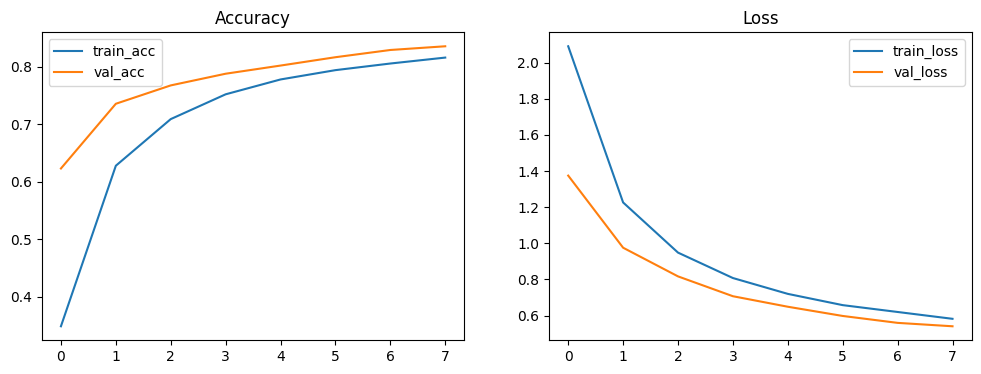

In [12]:

# Plot training curves (accuracy and loss)
if 'history' in globals():
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist['accuracy'], label='train_acc')
    plt.plot(hist['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
else:
    print('No history found. Run training cell.')


97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      0.95      0.89       150
                     Pepper__bell___healthy       0.97      0.95      0.96       222
                      Potato___Early_blight       0.99      0.90      0.94       150
                       Potato___Late_blight       0.90      0.86      0.88       150
                           Potato___healthy       0.94      0.74      0.83        23
                      Tomato_Bacterial_spot       0.75      0.94      0.83       320
                        Tomato_Early_blight       0.61      0.49      0.54       150
                         Tomato_Late_blight       0.81      0.86      0.83       287
                           Tomato_Leaf_Mold       0.66      0.87      0.75       143
                  Tomato_Septoria_leaf_spot       0.81      0.71      0.76       266
Tomato_Spider_mites_Two

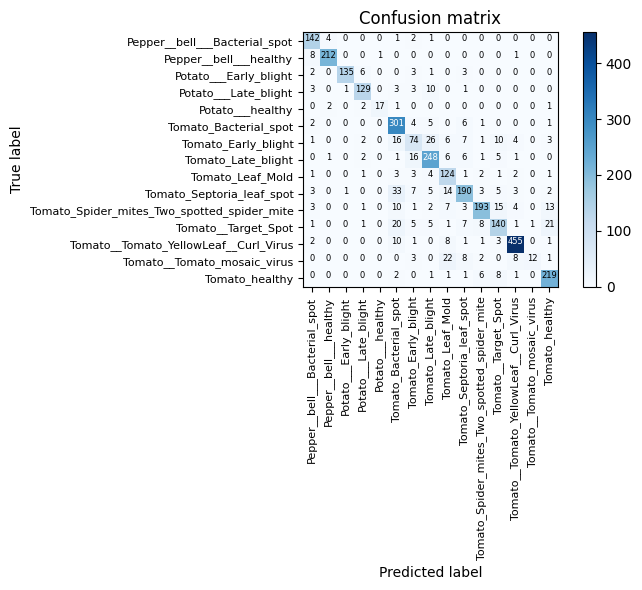

In [13]:

# Evaluate on validation/test set: confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def evaluate_model(model, val_gen):
    # Get predictions
    val_gen.reset()
    preds = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes
    labels = list(val_gen.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    return cm, labels

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black', fontsize=6)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

if 'model' in globals() and 'val_gen' in globals():
    cm, labels = evaluate_model(model, val_gen)
    plot_confusion_matrix(cm, labels, normalize=False)
else:
    print('Model or val_gen missing.')


In [14]:

# Save model and class indices (again) and show file sizes
if 'model' in globals():
    model_path = MODELS_DIR/'plantnet_v1.h5'
    model.save(model_path)
    print('Saved model to', model_path, ' size (MB):', model_path.stat().st_size/1e6)
if (MODELS_DIR/'class_indices.json').exists():
    with open(MODELS_DIR/'class_indices.json') as f:
        print('Class indices:', json.load(f))


Saved model to models/plantnet_v1.h5  size (MB): 9.8004
Class indices: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [15]:

# Single-image prediction helper
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as kimage

def load_saved_model(path=MODELS_DIR/'plantnet_v1.h5'):
    return load_model(str(path))

def preprocess_image(img_path, target_size=IMG_SIZE):
    img = kimage.load_img(img_path, target_size=target_size)
    arr = kimage.img_to_array(img)/255.0
    arr = np.expand_dims(arr, 0)
    return arr

def predict_image(model, img_path):
    with open(MODELS_DIR/'class_indices.json') as f:
        class_indices = json.load(f)
    inv_map = {v:k for k,v in class_indices.items()}
    x = preprocess_image(img_path)
    probs = model.predict(x)[0]
    idx = int(np.argmax(probs))
    return {'class': inv_map[idx], 'probability': float(probs[idx]), 'all_probs': probs.tolist()}

# Example (replace 'some_image.jpg' with a real path in your test set)
example = None
if TEST_DIR.exists():
    # grab a random test image
    classes = [d for d in TEST_DIR.iterdir() if d.is_dir()]
    c = random.choice(classes)
    example = list(c.glob('*'))[0]
    print('Example image:', example)
if example and (MODELS_DIR/'plantnet_v1.h5').exists():
    loaded = load_saved_model()
    print(predict_image(loaded, example))
else:
    print('No example prediction run. Ensure test data and model exist.')


Example image: data/test/Tomato_Spider_mites_Two_spotted_spider_mite/6a62f7da-c954-45df-b6c0-a679787750fa___Com.G_SpM_FL 1139.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
{'class': 'Tomato_Spider_mites_Two_spotted_spider_mite', 'probability': 0.9268664121627808, 'all_probs': [0.00032754449057392776, 3.0579267331631854e-05, 0.00015784850984346122, 0.00023488650913350284, 4.007886309409514e-05, 0.00022739596897736192, 0.004426118452101946, 0.000968690263107419, 0.011252930387854576, 0.0015886398032307625, 0.9268664121627808, 0.02670918218791485, 0.007828113622963428, 0.00388278067111969, 0.015458825044333935]}



Interpretations:
1) Class imbalance: some disease categories have many more images than others. This can bias model training and requires augmentation or class-weighting.
2) Brightness variability: many images have different lighting. Use augmentation (brightness, contrast) to improve generalization.
3) File size variability: images have varying resolutions and sizes; resizing to a fixed input size reduces training time and normalizes information content.


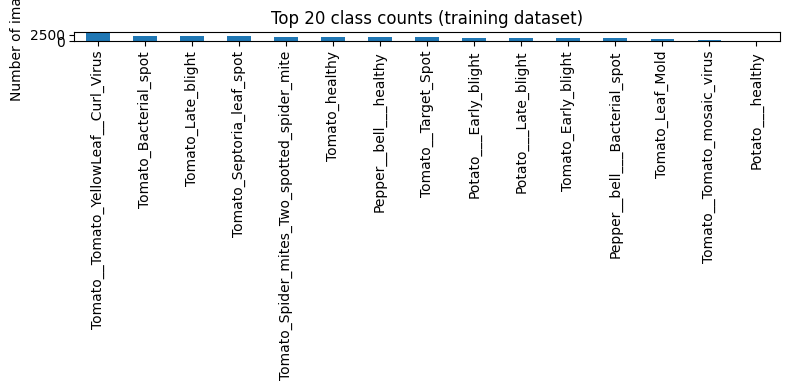

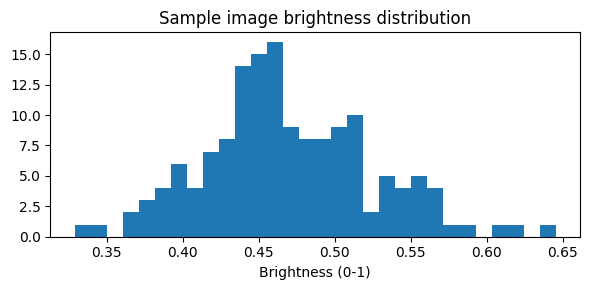

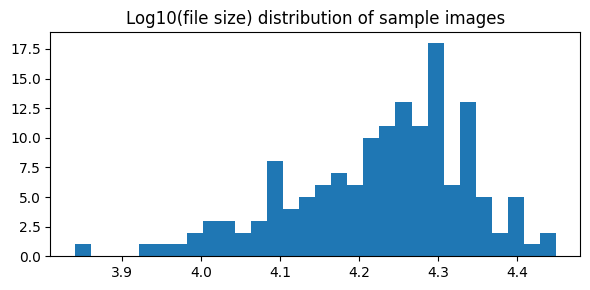

In [16]:

# Visualizations and interpretations for at least 3 features
# 1) Class distribution
if RAW_DIR.exists():
    counts = get_class_counts(RAW_DIR)
    dfc = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    plt.figure(figsize=(8,4))
    dfc['count'].head(20).plot.bar()
    plt.title('Top 20 class counts (training dataset)')
    plt.ylabel('Number of images')
    plt.tight_layout()

# 2) Image brightness distribution (sample)
def image_brightness(img_path):
    img = Image.open(img_path).convert('L').resize((100,100))
    arr = np.array(img)/255.0
    return arr.mean()

if RAW_DIR.exists():
    sample_paths = []
    for c in list(RAW_DIR.iterdir())[:20]:
        files = list(c.glob('*'))[:10]
        sample_paths += files
    br = [image_brightness(p) for p in sample_paths[:200]]
    plt.figure(figsize=(6,3))
    plt.hist(br, bins=30)
    plt.title('Sample image brightness distribution')
    plt.xlabel('Brightness (0-1)')
    plt.tight_layout()

# 3) Image size variations (file size bytes) - story: images come with different sizes which affects load time
if RAW_DIR.exists():
    sizes = [p.stat().st_size for p in sample_paths[:200]]
    plt.figure(figsize=(6,3))
    plt.hist(np.log10(sizes), bins=30)
    plt.title('Log10(file size) distribution of sample images')
    plt.tight_layout()

# Interpretations (markdown-like print)
print('\nInterpretations:')
print('1) Class imbalance: some disease categories have many more images than others. This can bias model training and requires augmentation or class-weighting.')
print('2) Brightness variability: many images have different lighting. Use augmentation (brightness, contrast) to improve generalization.')
print('3) File size variability: images have varying resolutions and sizes; resizing to a fixed input size reduces training time and normalizes information content.')


In [17]:

# Retraining workflow example (function-based) - for demo purposes
def retrain_on_new_data(new_data_dir, epochs=5):
    """new_data_dir should contain subfolders per class similar to data/train/
       This function will merge the new data into data/train (or you can switch paths) and fine-tune the model."""
    new_data_dir = Path(new_data_dir)
    assert new_data_dir.exists(), 'new_data_dir does not exist'
    # Copy into TRAIN_DIR (merge) - careful in production: validate and version data instead of simple copy
    for cls in new_data_dir.iterdir():
        if cls.is_dir():
            dest = TRAIN_DIR/cls.name
            dest.mkdir(parents=True, exist_ok=True)
            for f in cls.glob('*'):
                shutil.copy(f, dest/f.name)
    # Recreate generators and fine-tune
    train_gen, val_gen = get_generators(batch_size=16)
    # Load existing model and unfreeze some base layers for fine-tuning
    model = load_saved_model()
    base = model.layers[0]  # MobileNetV2 base is the first layer group; we will set trainable True carefully
    # set some layers trainable
    for layer in model.layers[-50:]:  # unfreeze last N layers - experiment with N
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    cb = [callbacks.ModelCheckpoint(str(MODELS_DIR/'plantnet_v_retrained.h5'), save_best_only=True),
          callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=cb)
    return model, history

# Example usage (for demonstration only)
print('Retrain function defined. To retrain, call retrain_on_new_data("/path/to/new/data_zip_unzipped")')


Retrain function defined. To retrain, call retrain_on_new_data("/path/to/new/data_zip_unzipped")
